In [1]:
from model import *
import numpy as np
from utils import *
import os, sys
from blendshapes import load_blendshape, BasicBlendshapes

## Helper functions

In [11]:
def manifold_projection(model, weights, blendshapes: BasicBlendshapes):
    proj_weights = model.infer(weights)
    if type(proj_weights) is torch.Tensor:
        proj_weights = proj_weights.detach().numpy()
    if len(weights.shape) == 1:
        V_proj = blendshapes.eval(proj_weights)
    else:
        # save the original shape
        original_shape = proj_weights.shape
        # reshape to 2D
        proj_weights = proj_weights.reshape(-1, proj_weights.shape[-1])   
        V_proj = np.zeros((proj_weights.shape[0], blendshapes.V.shape[0], 3))
        for i in range(proj_weights.shape[0]):
            V_proj[i] = blendshapes.eval(proj_weights[i])
        # reshape back to original shape, it could either be 3d or 4d
        try:
            V_proj = V_proj.reshape(original_shape[0], -1, 3)
        except:
            V_proj = V_proj.reshape(original_shape[0], original_shape[1], -1, 3)
        proj_weights = proj_weights.reshape(original_shape)
        return proj_weights, V_proj


## Naive Baselines

In [12]:
from regex import W


class NaiveLocal:
    def __init__(self, dim):
        self.weight = np.zeros(dim)
    def infer(self, x):
        return x
    
class Closest_K_Infer:
    def __init__(self, model, k=5):
        self.model = model
        self.k = k
    def infer(self, x):
        raw_output = self.model.infer(x)
        raw_output = raw_output.detach().numpy()
        x = x.detach().numpy()
        delta = raw_output - x
        # top k mask
        for i in range(x.shape[0]):
            mask = np.ones(len(raw_output[i]))
            mask[np.argsort(raw_output[i])[-self.k:]] = 0
            raw_output[i] = mask * delta[i] + x[i]
        return raw_output

## Inputs

In [13]:
# input paths
EXPERIMENT_PATH = "../experiments"
PROJ_ROOT = "../"

# models to compare
experiment_names = ["lipmlp"]
# experiment_names = os.listdir(EXPERIMENT_PATH)

################## For evaluating denoising performance ##################
# numbers of random frames to sample from the dataset
n_frames = 1000
# levels of noise
noise_levels = np.arange(0, 1, 0.1)

# other paths
BLENDSHAPES_PATH = os.path.join(PROJ_ROOT, "data", "AppleAR", "OBJs")
BLENDSHAPES_PATH = os.path.join(PROJ_ROOT, "data", "SP", "OBJs")

## Step 1: Evaluate model on de-noising reconstruction

### load models

In [14]:

models_dict = {}
for ii in range(len(experiment_names)):
    if experiment_names[ii][0] == ".":
        continue
    experiment_folder_path = os.path.join(EXPERIMENT_PATH, experiment_names[ii])
    config_path = os.path.join(experiment_folder_path, "config.json")
    config = json.load(open(config_path))
    
    # get type fo model
    try:
        model_type = config["network"]["type"]
        
    except:
        continue
    
    # load model
    try:
        model = load_model(config)
        models_dict[model_type] = model
        models_dict[model_type + "_ver_K"] = Closest_K_Infer(model)
    except:
        print("failed at {}".format(model_type))
        continue
models_dict["nothing"] = NaiveLocal(50)

/Users/evanpan/Documents/GitHub/ManifoldExploration/experiments/lipmlp/model.pt


### Load data and blendshapes

In [15]:
blendshapes = load_blendshape("SP")
dataset = load_dataset(dataset="SP")
weights_gt = random_sample(dataset, n_frames)

SP dataset size: 4225


### Metric 1 - reconstruction accuracy - evaluate the denoising capability of different models

In [16]:
from os import error
from librosa import ex
from numpy import dtype
from torch import mode


n_trials = 20
# noise levels
sv_samples = np.linspace(0, 1, n_trials)

# store error
noise_level_dict = {}
# store the error with respect to the ground truth
error_dict = {}

for model_name in models_dict:
    model = models_dict[model_name]
    for i in range(n_trials):
        sv = sv_samples[i] # different noise levels
        weights = weights_gt + np.random.normal(loc=0, scale=sv, size=weights_gt.shape)
        weights = np.clip(weights, 0, 1)
        weights = torch.from_numpy(weights).type(torch.FloatTensor)
        # weights and vertex positions
        proj_weights_dm, V_proj_dm = manifold_projection(model, weights, blendshapes)
        try:
            noise_level_dict[model_name].append(np.linalg.norm(weights - weights_gt))
            error_dict[model_name].append(np.linalg.norm(proj_weights_dm - weights_gt))
        except:
            noise_level_dict[model_name] = [np.linalg.norm(weights - weights_gt)]
            error_dict[model_name] = [np.linalg.norm(proj_weights_dm - weights_gt)]

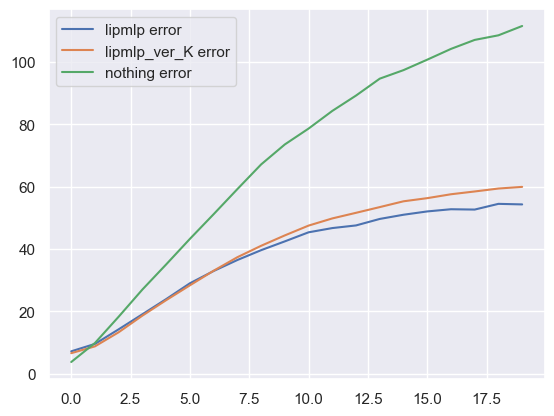

In [18]:
# plot the results
import matplotlib.pyplot as plt
# plt.figure()
for model_name in models_dict:
    plt.plot(error_dict[model_name], label=model_name + " error")
# plt.plot(noise_level_dict["naive"], label="noise level")
plt.legend()
plt.show()

### Metric 2 - Slider responsiveness - Locality

In [ ]:
def compute_locality_error(original_weight, modified_weight, projected_modified_weight, blendshapes):
    return np.linalg.norm(blendshapes.eval(original_weight) - blendshapes.eval(projected_modified_weight))

In [21]:
# make 100 changes per face from the dataset
n_trials = 100
# change a single variable and see if it can be 
locality_error = {}
for model_name in models_dict:
    model = models_dict[model_name]
    weights = weights_gt.copy()
    # add a new dimension
    weights = np.expand_dims(weights, axis=0)
    weights = np.repeat(weights, n_trials, axis=0)
    
    # generate n_trials where a single weight parameter is changed
    changed_mask = np.zeros(weights.shape, dtype=bool)
    # choose the weight index to change
    for i in range(n_trials): # per trial
        for j in range(0, weights.shape[1]): # per frame in dataset
            index = np.random.randint(0, weights.shape[2])
            changed_mask[i, j, index] = 1 
            
    # determine how much to change the weight by, sampling from normal distribution
    weight_delta = np.random.normal(loc=0, scale=0.5, size=[weights.shape[0] * weights.shape[1]])
    # make sure abs(weight_delta) > 0.1 so it's kind of significant
    weight_delta = np.sign(weight_delta) * np.maximum(np.abs(weight_delta), 0.1)
    modified_weights = weights.copy()
    modified_weights[changed_mask] += weight_delta
    modified_weights = np.clip(modified_weights, 0, 1)
    
    # iterate through the trials/frames to compute the error
    for i in range(n_trials):
        for j in range(weights.shape[1]):
            print(modified_weights.shape())
            proj_weights_dm, V_proj_dm = manifold_projection(model, torch.from_numpy(modified_weights[i, j]).type(torch.FloatTensor), blendshapes)
            locality_error = compute_locality_error(weights_gt[i, j], modified_weights[i, j], proj_weights_dm, blendshapes)

            try:
                locality_error[model_name].append(locality_error)
            except:
                locality_error[model_name] = [locality_error]
            A[2090293]

TypeError: cannot unpack non-iterable NoneType object